# Olfactory Bulb Glomerular Segmentation & Trace Extraction (Batch Processing)

**Goal:** Process a directory of two-photon imaging movies from individual trials. This notebook will:
1.  Create a representative "sampling movie" from random frames across all trials.
2.  Perform segmentation (CNMF) on this sampling movie to find a single, stable set of ROIs for the entire session.
3.  Loop through each individual trial video, apply motion correction, and extract fluorescence traces (F, dF/F, Z) using the common ROIs.
4.  Save all ROI information and all per-trial traces into a single, consolidated HDF5 file for easy downstream analysis.

**What you get at the end:**

1.  **Summary Figures** — Visual quality control for the segmentation performed on the sampling movie.
2.  **Single HDF5 Output** — A structured HDF5 file containing:
    -   Global ROI information (pixel locations, weights).
    -   Per-trial fluorescence traces for every kept ROI.
    -   All processing metadata and paths to summary figures.

### 0) Environment & Dependencies

*   Requires **CaImAn** and a typical scientific Python stack (`numpy`, `pandas`, `scipy`, `matplotlib`, `scikit-image`, `tifffile`).
*   Requires `h5py` for saving the final output. You can install it with `pip install h5py`.
*   Tested with Python 3.10–3.11 and CaImAn ≥ 1.9.

In [1]:
# --- Imports & Basic Setup ---
import os, sys, warnings, json, logging, h5py, re
from datetime import datetime
from pathlib import Path
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from tqdm.notebook import tqdm

# --- CalmAn imports ---
try:
    import caiman as cm
    from caiman.motion_correction import MotionCorrect
    from caiman.source_extraction.cnmf import params as caiman_params
    from caiman.source_extraction import cnmf as cnmf_mod
    from caiman.utils.visualization import plot_contours
    from caiman.cluster import setup_cluster, stop_server
except ImportError as e:
    raise ImportError("CaImAn not found. Please install CaImAn.") from e

from skimage.measure import regionprops
import scipy.ndimage

# --- Matplotlib defaults ---
plt.rcParams["figure.dpi"] = 120

# --- Suppress repetitive warnings ---
warnings.filterwarnings("ignore", message=".*nperseg.*", category=UserWarning)
warnings.filterwarnings("ignore", message=".*pkg_resources is deprecated.*", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1) Configure Paths & Parameters

**You must edit the `session_dir` variable in the cell below.** This should be the path to the main folder for your imaging session, which must contain a subdirectory named `raw` with your `.tif` files.

*   **Paths**:
    *   `session_dir`: The main directory for your experiment.
    *   `raw_dir`: The subdirectory containing your trial videos (must be named `raw`).
    *   `out_dir`: Where all outputs will be saved.
*   **Sampling**:
    *   `num_random_frames_per_trial`: The number of frames to randomly select from each trial video to build the segmentation movie.
*   **Acquisition & Heuristics**:
    *   `fr_manual`, `decay_time`, `dxy`, `w10`: These are the same core parameters as the single-file notebook and should be set based on your imaging setup.

In [8]:
# --- YOU MUST EDIT THIS --- 
# Path to the main session directory, which must contain a 'mcor' subfolder.
session_dir = Path("/Volumes/MossLab/ImagingData/20250829/e1/processed/")
# --- END EDIT --- 

# --- Derived Paths ---
raw_dir = session_dir / "mcor"
out_dir = session_dir / "outputs"
out_dir.mkdir(exist_ok=True, parents=True)
assert raw_dir.is_dir(), f"Input directory '{raw_dir}' not found!"

# --- Sampling Parameters ---
num_random_frames_per_trial = 5 # Number of frames to pull from each trial video

# --- Acquisition / field-of-view info ---
fr_manual = 24.0
decay_time = 0.1
dxy = (2, 2)
w10 = 20

# --- DERIVED PARAMETERS (ADVANCED) ---
mc_opts = dict(
    strides=(w10, w10), overlaps=(w10 // 2, w10 // 2), 
    max_shifts=(w10 // 2, w10 // 2), max_deviation_rigid=w10 // 4, pw_rigid=True)
K = 3
gSig = np.array([w10 // 2, w10 // 2])
gSiz = 2 * gSig + 1
min_SNR = 1.0
rval_thr = 0.3
merge_thr = 0.95
threshold_percentile = 15
convolution_threshold = 50
min_pixels = ((w10) ** 2) / 4
max_pixels = ((w10) ** 2) * 6

# --- Export Paths ---
sampling_movie_path = out_dir / "sampling_movie_for_segmentation.tif"
export_hdf5 = out_dir / "batch_analysis_results.hdf5"
summary_fig_A = out_dir / "summary_corr_max_overlays.png"
summary_fig_B_pdf = out_dir / "roi_panels.pdf"

print("Input trial directory:", raw_dir.resolve())
print("Outputs will be saved under:", out_dir.resolve())

Input trial directory: /Volumes/MossLab/ImagingData/20250829/e1/processed/mcor
Outputs will be saved under: /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs


### 2) Utility Functions

This cell contains all helper functions for the batch pipeline. This includes new functions for creating the sampling movie and for applying ROIs to extract traces from individual trials. You don't need to modify anything here.

In [15]:
# This cell contains all the refactored and new helper functions.
# You do not need to edit this cell.
def get_valid_tiff_files(directory):
    """
    Finds all TIFF files in a directory, robustly ignoring hidden macOS 
    resource files (those starting with '._').
    """
    all_files = sorted(list(directory.glob('*.tif')) + list(directory.glob('*.tiff')))
    valid_files = [f for f in all_files if not f.name.startswith('._')]
    return valid_files

# --- UPDATED FUNCTION THAT USES THE FIX ---
def create_sampling_movie(raw_dir, output_path, num_frames_per_trial):
    """
    Creates a movie from random frames of all TIFFs in a directory EFFICIENTLY.
    This version reads only the required frames from disk, avoiding high memory usage.
    """
    all_frames = []
    # Use our new robust function to get the file list
    trial_files = get_valid_tiff_files(raw_dir)
    
    if not trial_files:
        raise FileNotFoundError(f"No valid TIFF files found in {raw_dir}")
    
    print(f"Found {len(trial_files)} valid trial videos. Efficiently creating sampling movie...")

    for trial_path in tqdm(trial_files, desc="Sampling trials"):
        with tifffile.TiffFile(trial_path) as tif:
            num_total_frames = len(tif.series[0].pages)
            frame_indices = np.random.choice(num_total_frames, min(num_frames_per_trial, num_total_frames), replace=False)
            selected_frames = tif.asarray(key=frame_indices)
            all_frames.append(selected_frames)

    sampling_movie = np.concatenate(all_frames, axis=0)
    tifffile.imwrite(output_path, sampling_movie)
    print(f"Saved sampling movie with {sampling_movie.shape[0]} frames to: {output_path}")
    return output_path, sampling_movie

def extract_traces_for_trial(trial_movie, cleaned_A_list, dims, fr, percentile_q=8, baseline_win_max=1000):
    """Extracts F, dF/F, and Z traces for a single trial movie using pre-computed ROIs."""
    T = trial_movie.shape[0]
    d1, d2 = dims
    
    # Combine cleaned A components into a single sparse matrix
    # cleaned_A_list is a list of flat (d1*d2,) arrays
    A_cleaned = csr_matrix(np.stack(cleaned_A_list, axis=1))
    Yr = trial_movie.reshape((T, -1), order="F").T
    
    # Raw Fluorescence (F)
    F_weighted = A_cleaned.T @ Yr
    
    # Z-score
    mean_F = F_weighted.mean(axis=1, keepdims=True)
    std_F = F_weighted.std(axis=1, keepdims=True)
    std_F[std_F == 0] = 1 # Avoid division by zero for silent ROIs
    Z_traces = (F_weighted - mean_F) / std_F
    
    # dF/F
    def rolling_percentile(arr, q=percentile_q, win=None):
        win = win or min(baseline_win_max, 2 * (T // 10) + 1)
        return pd.DataFrame(arr.T).rolling(win, center=True, min_periods=1).quantile(q/100).to_numpy().T

    F0 = rolling_percentile(F_weighted)
    dFF_traces = (F_weighted - F0) / np.maximum(F0, 1e-6)
    
    return np.asarray(F_weighted), np.asarray(dFF_traces), np.asarray(Z_traces)

def save_batch_hdf5_output(output_path, df_pixels, all_trial_data, metadata_dict):
    """Saves all batch analysis outputs into a single structured HDF5 file."""
    with h5py.File(output_path, 'w') as f:
        # Save global ROI pixel info
        roi_info_group = f.create_group('roi_info')
        for col in df_pixels.columns:
            data = df_pixels[col].values
            if data.dtype == 'object': data = data.astype(str).astype(np.string_)
            roi_info_group.create_dataset(col, data=data)
        
        # Save per-trial data in separate groups
        trials_group = f.create_group('trials')
        for trial_name, trial_traces in all_trial_data.items():
            trial_group = trials_group.create_group(trial_name)
            trial_group.create_dataset('raw_F', data=trial_traces['F'])
            trial_group.create_dataset('dFF', data=trial_traces['dFF'])
            trial_group.create_dataset('z_score', data=trial_traces['Z'])
        
        # Save metadata as attributes
        meta_group = f.create_group('metadata')
        for key, val in metadata_dict.items():
            try:
                meta_group.attrs[key] = str(val) if isinstance(val, (dict, list, tuple, Path)) else val
            except TypeError:
                 meta_group.attrs[key] = str(val)
    print(f"Successfully saved all batch data to: {output_path}")



# --- (Most other utility functions like fit_cnmf, clean_components, etc. are reused from the previous notebook) ---
def get_scanimage_fps(movie_path, default_fr=None):
    try:
        with tifffile.TiffFile(movie_path) as tf:
            si_meta = getattr(tf, "scanimage_metadata", None)
            if isinstance(si_meta, dict):
                fps = si_meta.get("FrameData", {}).get("SI.hRoiManager.scanFrameRate")
                if fps: return float(fps)
    except Exception: pass
    return default_fr
def compute_qc_images(movie, q_low=5, q_high=98):
    movie_no_nan = np.nan_to_num(movie, nan=-np.inf)
    max_proj = np.max(movie_no_nan, axis=0)
    corr_img = cm.local_correlations(movie, swap_dim=False)
    corr_img[np.isnan(corr_img)] = 0
    vmax1, vmin1 = np.percentile(max_proj.ravel(), q_high), np.percentile(max_proj.ravel(), q_low)
    vmax2, vmin2 = np.percentile(corr_img.ravel(), q_high), np.percentile(corr_img.ravel(), q_low)
    return (max_proj, (vmin1, vmax1)), (corr_img, (vmin2, vmax2))
def build_cnmf_params(movie_path_str, frame_rate, dxy_tuple):
    rf_target, stride_target = int(w10 + 2), int(2 * w10 / 3)
    opts_dict = {"data": {"fnames": [movie_path_str], "fr": float(frame_rate), "dxy": tuple(map(float, dxy_tuple))},"decay_time": decay_time,"patch": {"rf": rf_target, "stride": stride_target, "only_init": False},"init": {"K": int(K), "gSig": [int(gSig[0]), int(gSig[1])], "gSiz": [int(gSiz[0]), int(gSiz[1])], "ssub": 1, "tsub": 1, "rolling_sum": False, "normalize_init": True, "center_psf": True, "nb": 1, "method_init": "greedy_roi"},"preprocess": {"check_nan": True},"temporal": {"p": 0},"merging": {"do_merge": True, "merge_thr": merge_thr},"quality": {"min_SNR": float(min_SNR), "rval_thr": float(rval_thr)}}
    return caiman_params.CNMFParams(params_dict=opts_dict)
# In your UTILITY FUNCTIONS CELL, replace the fit_cnmf function with this one:

def fit_cnmf(params, n_processes=1, dview=None, images=None, memmap_path=None):
    """
    Fits CNMF using either an in-memory array or a memory-mapped file, then refits.
    """
    if images is None and memmap_path is None:
        raise ValueError("You must provide either 'images' or 'memmap_path'.")

    model = cnmf_mod.CNMF(n_processes=n_processes, params=params, dview=dview)

    # --- CHOOSE FIT METHOD ---
    # <<< CHANGE: Use fit_file() if a path is provided, for better performance.
    if memmap_path is not None:
        print("  - Fitting CNMF using memory-mapped file (fit_file)...")
        model.fit_file(memmap_path)
    else:
        print("  - Fitting CNMF using in-memory array (fit)...")
        model.fit(images)
    
    print(f"[CNMF] Components after initial fit: {model.estimates.A.shape[1]}")

    # --- REFIT STEP (STILL IMPORTANT) ---
    # For refit, we need the movie data in memory. If we used fit_file, load it now.
    if memmap_path is not None:
        images_for_refit = cm.load(memmap_path)
    else:
        images_for_refit = images

    # Create a writable float32 copy for the refit process
    images2 = np.array(images_for_refit, dtype=np.float32, order="F", copy=True)
    np.nan_to_num(images2, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
    cnmf_refit = model.refit(images2)
    print(f"[CNMF] Components after refit: {cnmf_refit.estimates.A.shape[1]}")
    
    return cnmf_refit
def clean_components(fit, **kwargs):
    d1, d2 = fit.dims
    A_full = fit.estimates.A.toarray().reshape((d1, d2, -1), order="F")
    kept_indices, contours = [], {'valid':[], 'large':[], 'small':[], 'convoluted':[]}
    for k in range(A_full.shape[2]):
        comp = A_full[:, :, k]
        binary = comp > (kwargs['threshold_percentile'] / 100.0) * comp.max()
        labeled, n = scipy.ndimage.label(binary)
        if n == 0: continue
        mask = (labeled == (np.argmax(np.bincount(labeled.flat)[1:]) + 1))
        mask = scipy.ndimage.binary_fill_holes(mask)
        area = mask.sum()
        if area == 0: continue
        props = regionprops(mask.astype(int))[0]
        edge = scipy.ndimage.binary_dilation(mask) ^ mask
        if (props.perimeter ** 2) / props.area > kwargs['convolution_threshold']: contours['convoluted'].append(edge); continue
        if area > kwargs['max_pixels']: contours['large'].append(edge); continue
        if area < kwargs['min_pixels']: contours['small'].append(edge); continue
        kept_indices.append(k)
        contours['valid'].append(edge)
    A_cleaned_flat = [fit.estimates.A.toarray()[:, k] for k in kept_indices]
    print(f"Cleaned components: kept={len(contours['valid'])}, small={len(contours['small'])}, large={len(contours['large'])}, convoluted={len(contours['convoluted'])}")
    return {'kept_indices': kept_indices, 'cleaned_A_list': A_cleaned_flat, 'contours': contours}
def build_pixel_dataframe(fit, kept_indices):
    d1, d2 = fit.dims
    pixel_records = []
    A_csr = fit.estimates.A.tocsr()
    for comp_id in kept_indices:
        col = A_csr[:, comp_id].tocoo()
        if col.nnz == 0: continue
        pix_idx, w_raw = col.row, col.data.astype(float)
        w_norm = w_raw / (w_raw.sum() + 1e-10)
        y, x = (pix_idx % d1).astype(int), (pix_idx // d1).astype(int)
        pixel_records.append(pd.DataFrame({"ROI": comp_id, "pixel_idx": pix_idx, "y": y, "x": x, "weight_raw": w_raw, "weight_norm": w_norm}))
    return pd.concat(pixel_records, ignore_index=True) if pixel_records else pd.DataFrame()

### 3) Create Sampling Movie for Segmentation

This step creates the representative movie by pulling random frames from each trial video. This movie will be used *only for finding the ROIs*.

In [16]:
sampling_movie_path, sampling_movie = create_sampling_movie(
    raw_dir=raw_dir,
    output_path=sampling_movie_path,
    num_frames_per_trial=num_random_frames_per_trial
)

# Get frame rate from the first trial video
first_trial_path = sorted(list(raw_dir.glob('*.tif*')))[0]
fr = get_scanimage_fps(first_trial_path, default_fr=fr_manual)
print(f"Using frame rate for analysis: {fr:.2f} Hz")

Found 45 valid trial videos. Efficiently creating sampling movie...


Sampling trials:   0%|          | 0/45 [00:00<?, ?it/s]

Saved sampling movie with 225 frames to: /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/sampling_movie_for_segmentation.tif
Using frame rate for analysis: 24.00 Hz


### 4) CNMF Segmentation on Sampling Movie

Here, we run the core CNMF algorithm on the sampling movie. **Motion correction is NOT performed.** The goal is to identify a stable set of spatial footprints (ROIs) that are representative of the entire session.

In [17]:
# In your STEP 4 CELL, replace the entire content with this:

# Build CNMF params for the sampling movie
# We still need one frame to get the dimensions (d1, d2)
with tifffile.TiffFile(sampling_movie_path) as tif:
    first_frame = tif.asarray(key=0)
    dims = first_frame.shape

params = build_cnmf_params(str(sampling_movie_path), fr, dxy)

# Start cluster
dview = None
try:
    c, dview, n_processes = setup_cluster(backend='multiprocessing')
    print(f"[CNMF] Cluster ready with {n_processes} processes.")
except Exception as e:
    print(f"Could not start cluster, running on single process. Error: {e}")
    n_processes = 1

# Fit CNMF using the memory-mapped file path for better performance.
fit = fit_cnmf(
    params=params, 
    n_processes=n_processes, 
    dview=dview, 
    memmap_path=str(sampling_movie_path) # Pass the path, not the in-memory array
)

# Stop cluster
if dview is not None:
    stop_server(dview=dview)
    print("[CNMF] Cluster stopped.")

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


[CNMF] Cluster ready with 7 processes.
  - Fitting CNMF using memory-mapped file (fit_file)...


Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. S

[CNMF] Components after initial fit: 883


/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],


[CNMF] Components after refit: 883
[CNMF] Cluster stopped.


### 5) Clean Components & Generate QC Figures

We apply morphological and shape-based filters to the ROIs found in the previous step. The output is a final, high-quality set of ROIs that will be used for trace extraction across all trials. QC figures are generated to visualize which components were kept versus discarded.

Cleaned components: kept=320, small=401, large=0, convoluted=162


,ROI,pixel_idx,y,x,weight_raw,weight_norm
0,6,43808,8,73,0.008319,0.000623
1,6,43809,9,73,0.013980,0.001047
2,6,43810,10,73,0.008319,0.000623
3,6,44408,8,74,0.015434,0.001156
4,6,44409,9,74,0.015434,0.001156


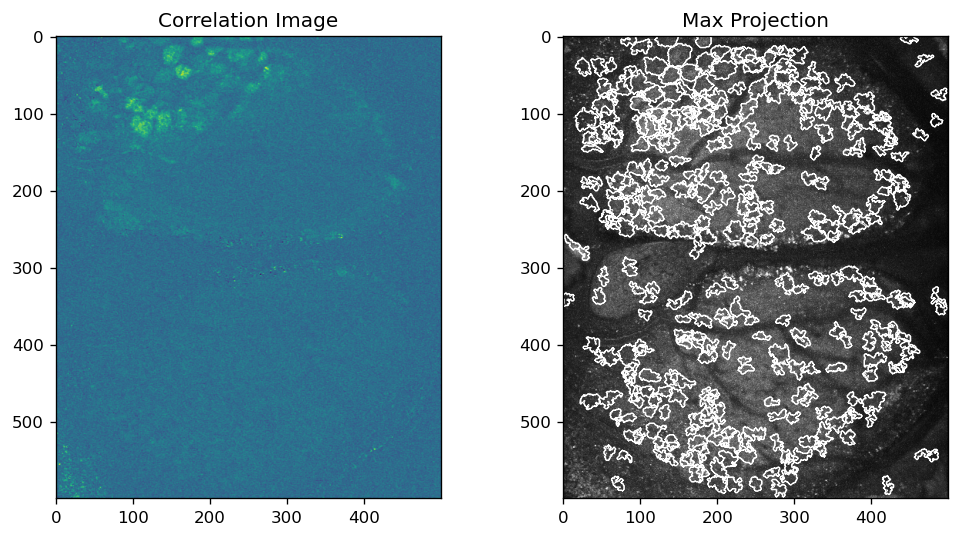

Saved summary figure to /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/summary_corr_max_overlays.png


In [18]:
cleaning_params = {
    'threshold_percentile': threshold_percentile,
    'min_pixels': min_pixels,
    'max_pixels': max_pixels,
    'convolution_threshold': convolution_threshold
}
clean_results = clean_components(fit, **cleaning_params)

kept_indices = clean_results['kept_indices']
cleaned_A_list = clean_results['cleaned_A_list']

# Build the global dataframe for ROI pixel information
df_pixels = build_pixel_dataframe(fit, kept_indices)
display(df_pixels.head())

# --- Generate QC Figures ---
max_proj, corr_img = compute_qc_images(sampling_movie)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(corr_img[0]); ax1.set_title('Correlation Image');
ax2.imshow(max_proj[0], cmap='gray'); ax2.set_title('Max Projection');
for contour in clean_results['contours']['valid']:
    ax2.contour(contour, colors='white', linewidths=0.5)
fig.savefig(summary_fig_A); plt.show()
print(f"Saved summary figure to {summary_fig_A}")

### 6) Process Individual Trials

Now we loop through each of the original trial videos in the `raw` directory. For each video, we:
1.  Directly load the already motion corrected trial file (motion corrected across files.
2.  Extract F, dF/F, and Z-scored traces using the globally defined set of ROIs.

In [19]:
all_trial_data = {}
trial_files = get_valid_tiff_files(raw_dir) # Use our new robust function

# --- Check if any trial files were found ---
if not trial_files:
    # If the list is empty, print an error and raise an exception to stop execution.
    error_message = f"ERROR: No TIFF files (.tif or .tiff) were found in the specified raw directory or directory does not exist: {raw_dir.resolve()}"
    print(error_message)
    # Raising a FileNotFoundError is good practice here.
    raise FileNotFoundError(error_message)
else:
    # --- If files are found, proceed with the loop as before ---
    print(f"Found {len(trial_files)} trial videos to process...")
    
    # Wrap the loop with a tqdm progress bar.
    for trial_path in tqdm(trial_files, desc="Processing Trials"):
        trial_name = trial_path.stem # Use filename without extension as identifier
        
        # Load the raw trial movie directly (skipping motion correction).
        trial_movie_raw = cm.load(str(trial_path))
        dims = trial_movie_raw.shape[1:]
        
        # Extract Traces using the common ROIs.
        if cleaned_A_list:
            F, dFF, Z = extract_traces_for_trial(
                trial_movie=trial_movie_raw, 
                cleaned_A_list=cleaned_A_list, 
                dims=dims, 
                fr=fr
            )
            all_trial_data[trial_name] = {'F': F, 'dFF': dFF, 'Z': Z}
        else:
            # This case would only be hit if segmentation found zero valid ROIs.
            print(f"  - No kept ROIs, skipping trace extraction for {trial_name}.")
        
        # Clean up the large movie array to free up RAM before the next loop iteration.
        del trial_movie_raw

    print("\n--- All trials processed successfully! ---")

Found 45 trial videos to process...


Processing Trials:   0%|          | 0/45 [00:00<?, ?it/s]


--- All trials processed successfully! ---


### 7) Save Consolidated HDF5 Output

All data is now saved to a single HDF5 file. The file is structured with top-level groups for `roi_info` (global) and `trials`. The `trials` group contains a subgroup for each trial video, which in turn holds the `raw_F`, `dFF`, and `z_score` datasets for that trial.

In [20]:
# --- Prepare Metadata ---
meta = dict(
    source_directory=str(raw_dir.resolve()),
    created_utc=datetime.utcnow().isoformat() + "Z",
    fr=fr, dxy=dxy, decay_time=decay_time, K_init=int(K),
    num_rois_kept=len(kept_indices),
    thresholds=cleaning_params,
    output_files=dict(
        summary_figure_A=str(summary_fig_A.resolve()),
        sampling_movie=str(sampling_movie_path.resolve())
    )
)

# --- Save to HDF5 ---
save_batch_hdf5_output(
    output_path=export_hdf5,
    df_pixels=df_pixels,
    all_trial_data=all_trial_data,
    metadata_dict=meta
)

Successfully saved all batch data to: /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/batch_analysis_results.hdf5


### 8) Final Cleanup (Optional)

This final step cleans up all the temporary memory-mapped (`.mmap`) files created by CaImAn during the motion correction of each individual trial.

In [ ]:
import os
from pathlib import Path

caiman_temp_dir = Path.home() / 'caiman_data' / 'temp'
print(f"--- Starting Cleanup of CaImAn Temporary Files ---")
print(f"Target directory: {caiman_temp_dir}")

if caiman_temp_dir.is_dir():
    try:
        temp_files = [f for f in caiman_temp_dir.iterdir() if f.is_file()]
        if not temp_files:
            print("Status: Temporary directory is empty. No files to delete.")
        else:
            num_deleted = 0
            for f_path in temp_files:
                try:
                    f_path.unlink()
                    num_deleted += 1
                except OSError as e:
                    print(f"  - ERROR: Could not delete {f_path.name}. Reason: {e}")
            print(f"\nCleanup complete. Successfully deleted {num_deleted} file(s).")
    except Exception as e:
        print(f"An unexpected error occurred during cleanup: {e}")
else:
    print("Status: Temporary directory not found. No cleanup was necessary.")